# Neural Network to train MNIST dataset in PyTorch

### Import required packages

In [3]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#### 3 ways to load MNIST Dataset

1. Using torchvision.datasets.MNIST DataLoader num_workers = default (0)

In [30]:
# Transform (normalize to [0,1])
transform = transforms.ToTensor()

# Load MNIST data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64)
test_loader  = DataLoader(test_dataset, batch_size=64)

2. Using torchvision.datasets.MNIST DataLoader num_workers = 2

In [35]:
# Transform (normalize to [0,1])
transform = transforms.ToTensor()

# Load MNIST data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=64, num_workers=2)

3. Preloading images in tensors

In [40]:
import idx2numpy
from torch.utils.data import TensorDataset

# Path to dataset files
rel_path_train_images = 'data/MNIST/raw/train-images-idx3-ubyte'
rel_path_train_labels = 'data/MNIST/raw/train-labels-idx1-ubyte'
rel_path_test_images = 'data/MNIST/raw/t10k-images-idx3-ubyte'
rel_path_test_labels = 'data/MNIST/raw/t10k-labels-idx1-ubyte'

# Converting to numpy array
train_images = idx2numpy.convert_from_file(rel_path_train_images)
X_train = train_images.reshape((60000, 28, 28))    
X_train = X_train / 255

Y_train = idx2numpy.convert_from_file(rel_path_train_labels)

test_images = idx2numpy.convert_from_file(rel_path_test_images)
X_test = test_images.reshape((10000, 28, 28))    
X_test = X_test / 255

Y_test = idx2numpy.convert_from_file(rel_path_test_labels)

# Loading torch.tensor in train_loader and test_loader
X_train = torch.tensor(X_train, dtype=torch.float32)  # shape: (60000, 28, 28)
Y_train = torch.tensor(Y_train, dtype=torch.long)     # shape: (60000,)
X_train = X_train.unsqueeze(1)
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

X_test = torch.tensor(X_test, dtype=torch.float32)  # shape: (60000, 28, 28)
Y_test = torch.tensor(Y_test, dtype=torch.long)
X_test = X_test.unsqueeze(1)
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size = 64)

torch.Size([64, 1, 28, 28])
64
torch.Size([64])
64


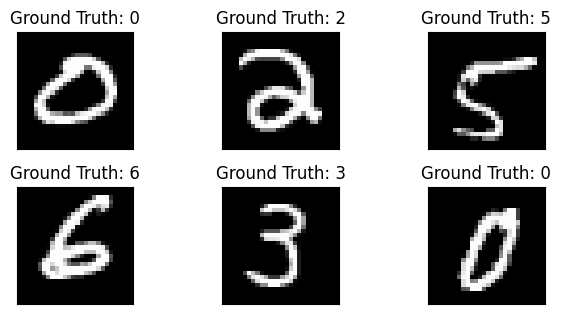

In [41]:
for images, labels in train_loader:
    print(images.shape)
    print(len(images))
    print(labels.shape)
    print(len(labels))
    for i in range(6):
        plt.subplot(3, 3, 1 + i)
        plt.tight_layout()
        plt.imshow(images[i].reshape((28,28)), cmap=plt.get_cmap('gray'))
        plt.title(f'Ground Truth: {labels[i]}')
        plt.xticks([])
        plt.yticks([])
    plt.show()
    break

#### Define the Neural Network

In [42]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),                  # (28x28) → (784)
            nn.Linear(784, 128),
            nn.ReLU(),
            # nn.Linear(64, 32),
            # nn.ReLU(),
            nn.Linear(128, 10)             # No Softmax here (CrossEntropyLoss handles it)
        )
    
    def forward(self, x):
        return self.model(x)

model = MNISTModel()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

#### Training your model

In [43]:
import time

epochs = 10
start_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        outputs = model(images)
        loss = loss_func(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    accuracy = correct / total * 100
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nTotal training time: {elapsed_time:.2f} seconds")


Epoch 1/10, Loss: 1.2514, Accuracy: 73.90%
Epoch 2/10, Loss: 0.4977, Accuracy: 87.50%
Epoch 3/10, Loss: 0.3951, Accuracy: 89.25%
Epoch 4/10, Loss: 0.3546, Accuracy: 90.08%
Epoch 5/10, Loss: 0.3302, Accuracy: 90.71%
Epoch 6/10, Loss: 0.3128, Accuracy: 91.17%
Epoch 7/10, Loss: 0.2987, Accuracy: 91.63%
Epoch 8/10, Loss: 0.2867, Accuracy: 91.94%
Epoch 9/10, Loss: 0.2756, Accuracy: 92.26%
Epoch 10/10, Loss: 0.2657, Accuracy: 92.52%

Total training time: 12.67 seconds


#### Evaluate model on test data

In [44]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct / total * 100:.2f}%")

Test Accuracy: 93.03%


#### Comparison
(After 10 epochs)

1. Using Datasets.MNIST (num_workers = 0)
     - Training time = 79.05 secs 
     - Train accuracy = 95.62 %
     - Test accuracy = 95.32 %
2. Using Datasets.MNIST (num_workers = 2)
     - Training time = 89.73 secs
     - Train accuracy = 95.70 %
     - Test accuracy = 95.16 %
3. Using Preloaded Tensors
     - Training time = 20.74 secs
     - Train accuracy = 95.54 %
     - Test accuracy = 95.23 %